# Introduction

Codebase for Analysing the Hateful Memes Dataset    

by :- Tarun Teppala

Preface: The code has been tuned to run on a laptop GPU (Nvidia GTX 1650) and is extremely weak and unoptimized

The following are the objective tasks:

 - Object Detection
 - Caption Impact Assessment
 - Classification System Development
 - Bonus: Image-only label classifier
 - Bonus: Text-only label classifier


# Codebase

## Imports

In [1]:
import json
import os
import easyocr
import torch
import torchvision
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from enum import Enum

## Download Dataset

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('facebook-hateful-meme-dataset', path='./', unzip=True)

## Classes

In [5]:
class DatasetType(Enum):
    dev = "dev"
    test = "test"
    train = "train"

In [6]:
class HatefulMemesPreprocessing(Dataset):
    def __init__(self, dataset: DatasetType, caption_mask: bool = False, vocab: dict = {}, normalize: dict = None, extra_transforms: list[callable] = None):
        self.dir = './data'
        self.transform = []
        self.data = []
        self.vocab = vocab

        if caption_mask: self.transform.append(self.EasyOCRMasker(gpu=True, visualize=True))

        if extra_transforms:
            for t in extra_transforms:
                if not callable(t):
                    raise ValueError(f"Invalid transform: {t}. Must be a callable transformer")
            self.transform = extra_transforms.extend(self.transform)
        self.transform.append(transforms.ToTensor())
        if normalize:
            if (normalize.mean and normalize.std): self.transform.append(transforms.Normalize(mean = normalize.mean ,std = normalize.std))

        
        with open(os.path.join(self.dir, dataset + '.jsonl'), 'r') as f:
            for line in f:
                entry = json.loads(line.strip())
                self.data.append(entry)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
         
        entry = self.data[idx]
        text = entry['text']
        
        tokens = text.lower().split()
        text = text.translate(str.maketrans('', '', string.punctuation))
        sequence = [self.vocab.get(token, 0) for token in tokens]
        entry['text_corpus']=sequence
        
        img_path = os.path.join(self.dir, entry['img'])
        
        image = Image.open(img_path).convert('RGB')  
        entry['image_size'] = image.size
        
        transformer = transforms.Compose(self.transform)
        
        image = transformer(image)
        return image, entry  
    
    class EasyOCRMasker:
        def __init__(self, gpu=True, visualize=True):
            
            self.reader = easyocr.Reader(['en'], gpu=gpu)  
            self.visualize = visualize

        def __call__(self, image):
            
            
            ocr_result = self.reader.readtext(np.array(image))
            
            if self.visualize:
                
                image = self._visualize_ocr_results(image, ocr_result)

            
            return image

        def _visualize_ocr_results(self, image, ocr_result):
            
            
            draw = ImageDraw.Draw(image)
            
            for bbox, _, _ in ocr_result:

                
                
                xy = []
                for l in bbox:
                    xy.append((l[0],l[1]))
                
                draw.polygon(xy, fill='white') 
            return image  

In [7]:
class HatefulMemesDataset(Dataset):
    def __init__(self, jsonl_file):
        self.data = []

        # Load the JSONL data
        with open(jsonl_file, 'r') as f:
            for line in f:
                entry = json.loads(line.strip())
                self.data.append(entry)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        # Extract text corpus as a tensor
        text_corpus = torch.tensor(entry['text_corpus'], dtype=torch.long)

        # Extract image detection feature (confidence scores only)
        image_detection = entry['image_detection']
        if image_detection:
            image_features = torch.tensor([det[2] for det in image_detection], dtype=torch.float)
        else:
            image_features = torch.tensor([])  # Empty tensor if no image detection

        # Extract label
        label = torch.tensor(entry['label'], dtype=torch.long)

        return text_corpus, image_features, label

# Collate function for dynamic padding
def collate_fn(batch):
    text_sequences = [item[0] for item in batch]
    image_features = [item[1] for item in batch]
    labels = torch.tensor([item[2] for item in batch], dtype=torch.long)

    # Pad text sequences to the same length
    text_sequences_padded = pad_sequence(text_sequences, batch_first=True)

    # Pad image features if necessary
    if any([feat.numel() > 0 for feat in image_features]):
        max_len = max([feat.size(0) for feat in image_features])
        image_features_padded = torch.stack([
            torch.cat([feat, feat.new_zeros(max_len - feat.size(0))]) if feat.numel() > 0 else torch.zeros(max_len)
            for feat in image_features
        ])
    else:
        image_features_padded = None

    return text_sequences_padded, image_features_padded, labels

## Utility functions

### Data conversion

In [8]:

vocab = {}

def build_vocab_from_jsonl(file: str, vocab: dict = {}):
    
    with open('./data/' + file + '.jsonl', 'r') as f:
            for line in f:
                entry = json.loads(line.strip())
                tokens = entry['text'].lower().split()
                for t in tokens:
                     if t not in vocab.keys():
                          t = t.translate(str.maketrans('', '', string.punctuation))
                          vocab[t]= len(vocab.keys()) + 1

build_vocab_from_jsonl('dev',vocab)
build_vocab_from_jsonl('test',vocab)
build_vocab_from_jsonl('train',vocab)

In [9]:
def jsonl_to_dataframe_pivottable(file_path, weights):
    data = []

    with open(file_path, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            if entry['label']:
                label = entry['label']  
            detections = entry['image_detection']
            if detections == []:
                if entry['label']:
                    data.append({"class_label": 'unidentified', "image_label": label})
                else:
                    data.append({"class_label": 'unidentified'})
            
            for detection in detections:
                
                class_label = weights.meta['categories'][detection[1]]  
                confidence = detection[2]
                if entry['label']:
                    data.append({
                    "class_label": class_label,
                    "image_label": label,
                    "confidence": confidence
                })
                else:
                    data.append({
                    "class_label": class_label,
                    "confidence": confidence
                })  
                

    
    df = pd.DataFrame(data)
    return df

In [10]:
def custom_collate_fn(batch):
    text_sequences = [item[0] for item in batch]
    image_features = [item[1] for item in batch]
    labels = torch.tensor([item[2] for item in batch], dtype=torch.long)

    
    text_sequences_padded = pad_sequence(text_sequences, batch_first=True, padding_value=0)

    # Pad image features if necessary
    if any([feat.numel() > 0 for feat in image_features]):
        max_len = max([feat.size(0) for feat in image_features])
        image_features_padded = torch.stack([
            torch.cat([feat, feat.new_zeros(max_len - feat.size(0))]) if feat.numel() > 0 else torch.zeros(max_len)
            for feat in image_features
        ])
    else:
        image_features_padded = None

    return text_sequences_padded, image_features_padded, labels


### Data visulaization

In [11]:
def plot_stacked_bar_chart(df, dataset, masked):
      # Custom colors for labels 0 and 1
    pivot_table = df.pivot_table(
        index='class_label',
        columns='image_label',
        aggfunc='size',
        fill_value=0
    )
    ax = pivot_table.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        color=['blue','red']  # Use custom colors
    )

    # Annotate the bars with the counts
    totals = pivot_table.sum(axis=1)  # Sum each row to get totals per class
    for idx, total in enumerate(totals):
        ax.text(
            idx, total + 0.5,  # Position the text slightly above the bar
            str(total), 
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )
    dataset_desc = 'Dataset: ' + dataset + ' TextMasked: ' + str(masked)
    # Set labels and title
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Frequency')
    ax.set_title('Stacked Bar Chart of Class Frequencies by Image Labels' + '\n' + dataset_desc)
    

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Image Label', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.savefig(dataset_desc.replace(' ','').replace(':','') + 'BarChart.png')
    plt.show()

In [12]:
def normalize_and_display_distribution(df, dataset, masked):
    # Normalize the data by dividing each value by the sum of all values per class
    pivot_table = df.pivot_table(
        index='class_label',
        columns='image_label',
        aggfunc='size',
        fill_value=0
    )
    normalized_table = pivot_table.div(pivot_table.sum(axis=1), axis=0)

    # print("Normalized Data:")
    # print(normalized_table)

    # Plot the normalized distribution
    ax = normalized_table.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        colormap='coolwarm'
    )

    # Annotate bars with both counts and normalized values
    for class_idx, (class_label, row) in enumerate(normalized_table.iterrows()):
        for label_idx, (image_label, value) in enumerate(row.items()):
            if value > 0:  # Only annotate non-zero values
                # Retrieve the original count from the pivot table
                original_count = pivot_table.loc[class_label, image_label]

                # Annotate the bar segment
                ax.text(
                    class_idx,  # X-axis position (class label index)
                    row[:label_idx + 1].sum() - value / 2,  # Y-axis position (center of the segment)
                    f'{original_count}',  # Example: "3 (0.75)"
                    ha='center', va='center', fontsize=5, color='black'
                )
    dataset_desc = 'Dataset: ' + dataset + ' TextMasked: ' + str(masked)
    # Set labels and title
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Normalized Frequency')
    ax.set_title('Normalized Distribution of Class Frequencies by Image Labels' + '\n' + dataset_desc)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Image Label', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.savefig(dataset_desc.replace(' ','').replace(':','') + 'NormalizedChart.png')
    plt.show()

In [13]:
def display_confidence_table_and_plot(df, dataset, masked):
    # print("Average Confidence per Class and Label:")
    # print(avg_confidence)
    pivot_table = pivot_table = df.pivot_table(
        index='class_label',
        columns='image_label',
        values='confidence',
        aggfunc='mean',  # Aggregate using mean confidence
        fill_value=0
    )
    
    avg_confidence = pivot_table.apply(lambda x: round(x*100,4))
    # print(avg_confidence)
    # Plot the average confidence using a bar chart
    ax = avg_confidence.plot(
        kind='bar',
        figsize=(12, 6),
        colormap='coolwarm'
    )
    dataset_desc = 'Dataset: ' + dataset + ' TextMasked: ' + str(masked)
    # Set labels and title
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Average Confidence')
    ax.set_title('Average Confidence per Class and Label' + '\n' + dataset_desc)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=5)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Image Label', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.savefig(dataset_desc.replace(' ','').replace(':','') + 'ConfidenceChart.png')
    plt.show()


In [14]:
def display_confidence_comparison(df, masked_df, dataset):
    # Create pivot tables for both dataframes
    pivot_table_df = df.pivot_table(
        index='class_label',
        columns='image_label',
        values='confidence',
        aggfunc='mean',
        fill_value=0
    )
    
    pivot_table_masked_df = masked_df.pivot_table(
        index='class_label',
        columns='image_label',
        values='confidence',
        aggfunc='mean',
        fill_value=0
    )

    # Round the confidence values for better display
    avg_confidence_df = pivot_table_df.apply(lambda x: round(x * 100, 4))
    avg_confidence_masked_df = pivot_table_masked_df.apply(lambda x: round(x * 100, 4))

    # Combine both pivot tables for side-by-side comparison
    combined_confidence = pd.concat(
        {'Original': avg_confidence_df, 'Masked': avg_confidence_masked_df},
        axis=1
    )

    # Plot the combined bar chart
    ax = combined_confidence.plot(
        kind='bar',
        figsize=(12, 6),
        colormap='coolwarm',
        width=0.8
    )

    # Set labels and title
    dataset_desc = f'Dataset: {dataset}'
    ax.set_xlabel('Class Labels')
    ax.set_ylabel('Average Confidence (%)')
    ax.set_title('Average Confidence per Class and Label\n' + dataset_desc)

    # Annotate bars with values
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=6)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Data Type and Image Label', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(dataset_desc.replace(' ', '').replace(':', '') + 'ConfidenceComparisonChart.png')
    plt.show()

## Models

In [15]:
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights


weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
preprocess_model = ssdlite320_mobilenet_v3_large(weights=weights, score_thresh=0.7)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preprocess_model.to(device)
import torch.backends.cudnn as cudnn
if device == 'cuda':
    model = torch.nn.DataParallel(preprocess_model)
    cudnn.benchmark = True
print(device,':',torch.cuda.get_device_name())

cuda : NVIDIA GeForce GTX 1650


In [16]:
# from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights

# weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.95)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)
# print(device,':',torch.cuda.get_device_name())

In [17]:
def detect_objects_and_save(model, dataloader, device,name,mask=''):
    
    model.eval()  
    output_file = './'+name+mask+'_obj_det.jsonl'
    with open(output_file, 'w') as f_out:
        for images, entries in dataloader:
            
            images = [img.to(device) for img in images]

            
            with torch.no_grad():
                outputs = model(images)  

            
            for entry, output in zip(entries, outputs):
                image_size = entry['image_size']  # (width, height)
                image_midpoint = (image_size[0] / 2, image_size[1] / 2)

                
                boxes = output['boxes'].tolist()  
                labels = output['labels'].tolist()  
                scores = output['scores'].tolist()  

                
                detections = list(zip(boxes, labels, scores))

                
                top_detections = sorted(detections, key=lambda x: x[2], reverse=True)[:5]

                
                def calculate_distance(box):
                    x1, y1, x2, y2 = box  
                    box_midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  
                    distance = ((box_midpoint[0] - image_midpoint[0]) ** 2 + (box_midpoint[1] - image_midpoint[1]) ** 2) ** 0.5
                    return distance

                
                nearest_detection = sorted(top_detections, key=lambda x: calculate_distance(x[0]))[:1]
                
                entry['image_detection'] = nearest_detection
                json.dump(entry, f_out)
                f_out.write('\n')
    
    return output_file
    
          

            

## Task A: Object detection

In [18]:
dataset = HatefulMemesPreprocessing(dataset='dev', vocab=vocab, caption_mask=False)
dev_dataloader = DataLoader(dataset, batch_size=16, shuffle=False,pin_memory=True, collate_fn=lambda x: list(zip(*x)))

In [19]:

df = jsonl_to_dataframe_pivottable(detect_objects_and_save(preprocess_model,dev_dataloader,device,'dev'),weights)

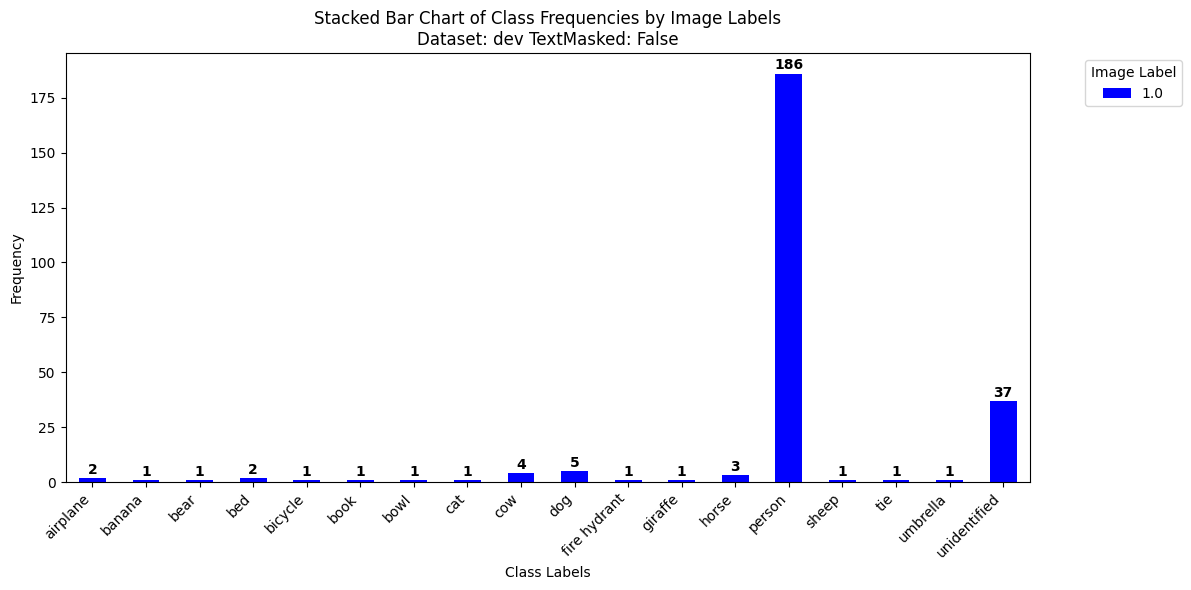

In [20]:
plot_stacked_bar_chart(df,'dev',False)

C:\Users\tarun\AppData\Local\Temp\ipykernel_16872\464794868.py:32: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  row[:label_idx + 1].sum() - value / 2,  # Y-axis position (center of the segment)


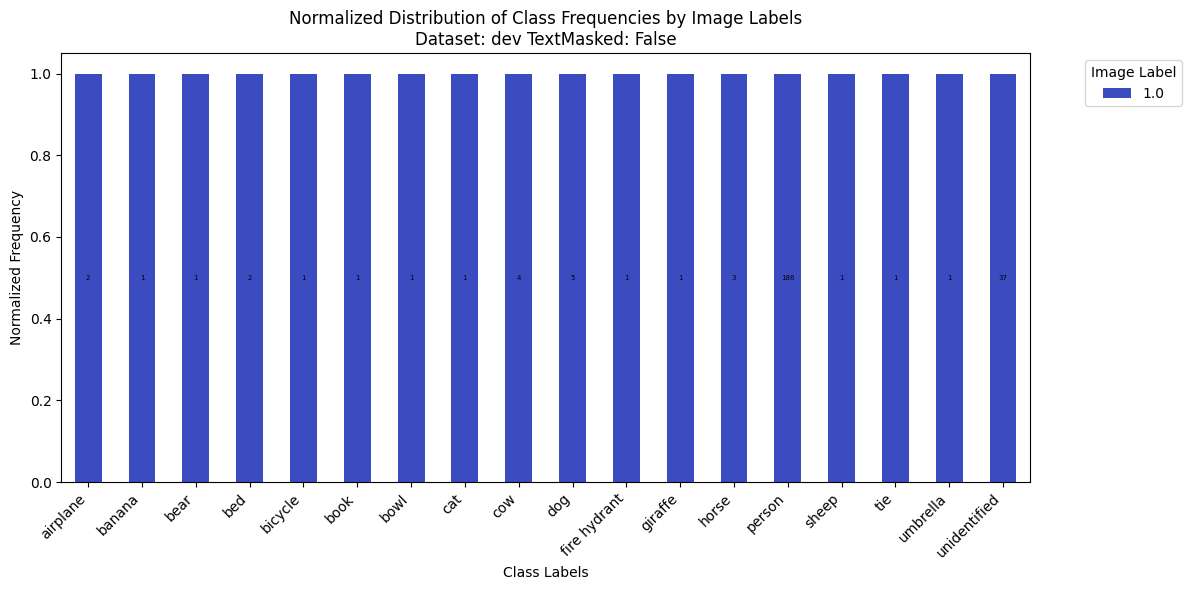

In [21]:
normalize_and_display_distribution(df,'dev',False)

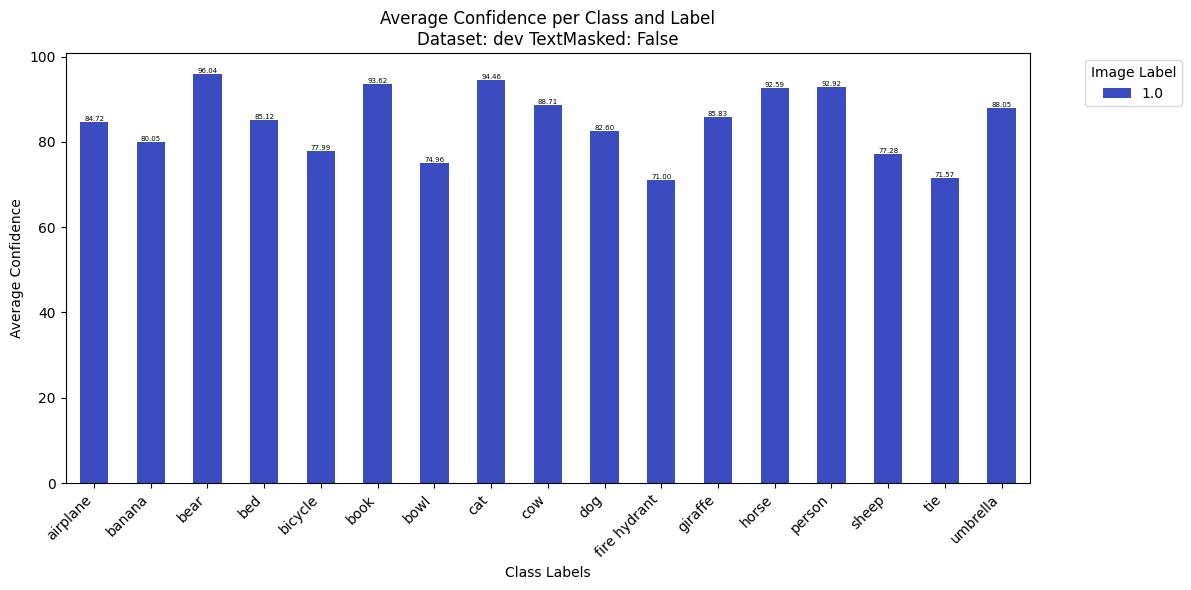

In [22]:
display_confidence_table_and_plot(df,'dev',False)

## Task B: Caption Impact Assessment:

In [166]:
masked_dataset = HatefulMemesPreprocessing(dataset='dev', vocab=vocab, caption_mask=True)
dev_masked_dataloader = DataLoader(masked_dataset, batch_size=16, shuffle=False,pin_memory=True, collate_fn=lambda x: list(zip(*x)))

In [167]:
masked_df = jsonl_to_dataframe_pivottable(detect_objects_and_save(preprocess_model,dev_masked_dataloader,device,'dev'),weights)

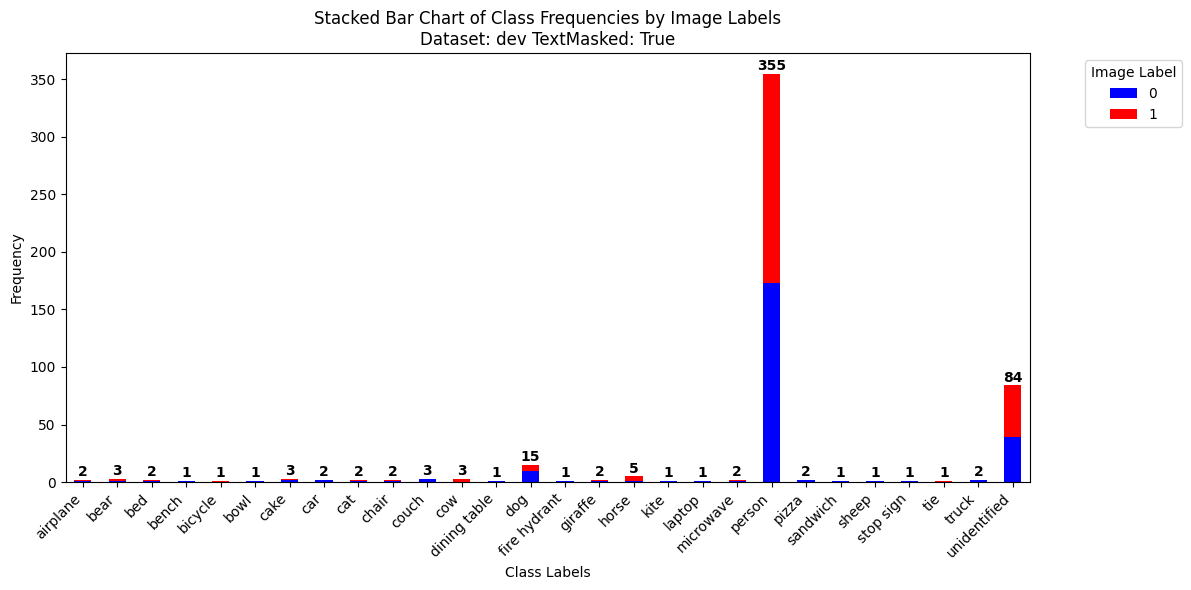

In [168]:
plot_stacked_bar_chart(masked_df,'dev',True)

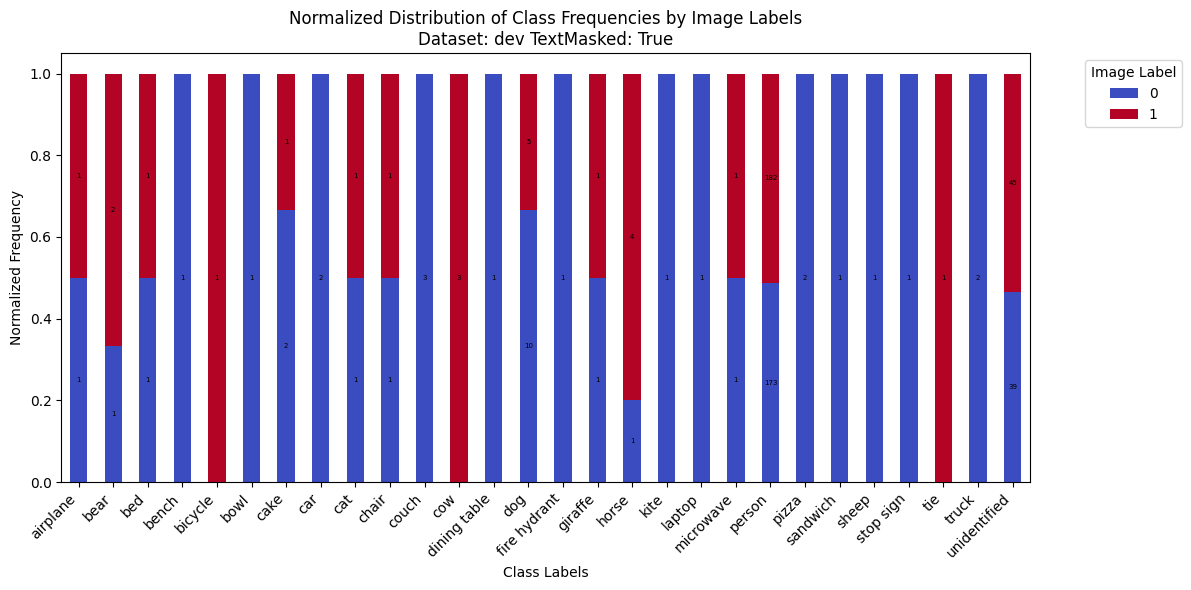

In [169]:
normalize_and_display_distribution(masked_df,'dev',True)

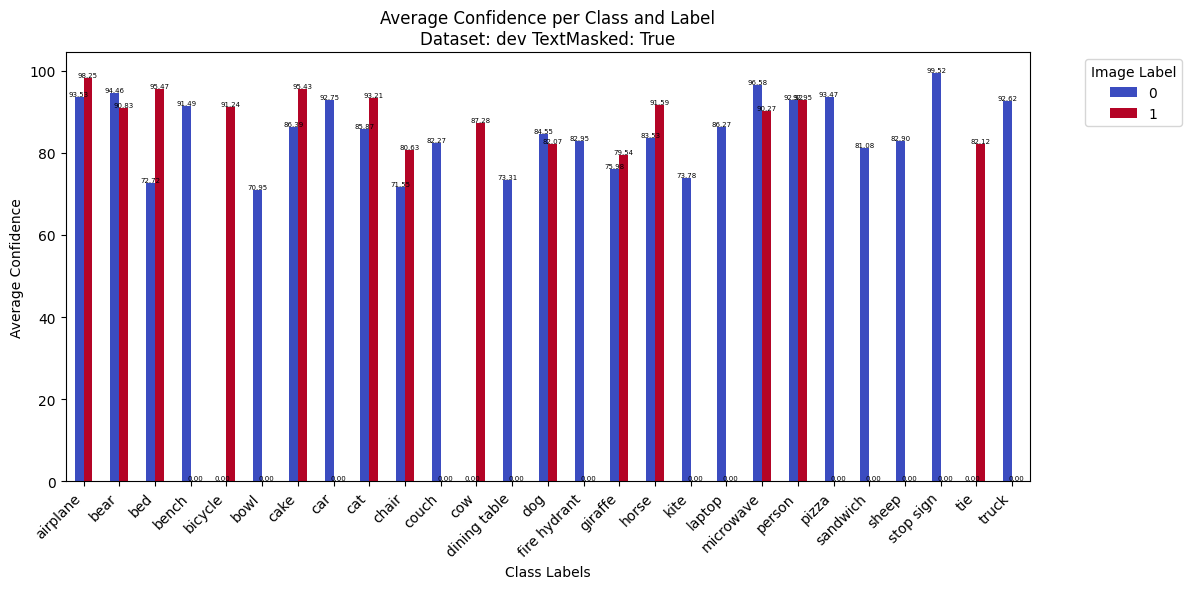

In [173]:
display_confidence_table_and_plot(masked_df,'dev',True)

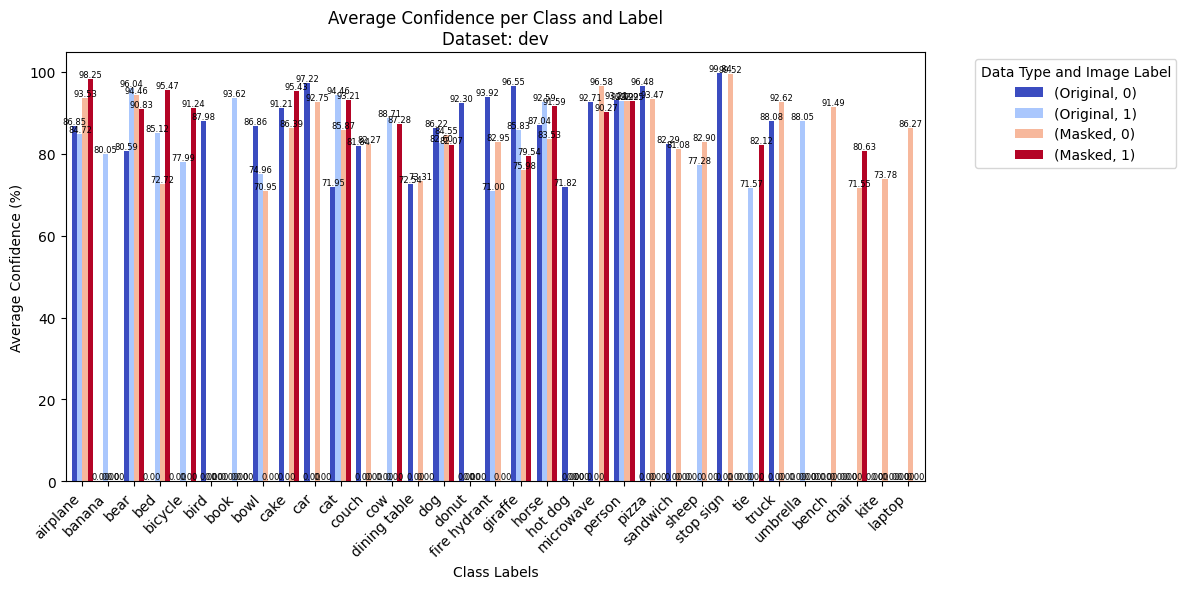

In [174]:
display_confidence_comparison(df,masked_df,'dev')


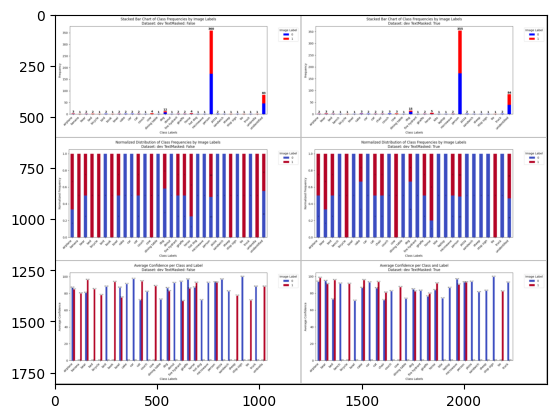

In [29]:
from torchvision.io import read_image 
from torchvision.utils import make_grid 
import matplotlib.image as mpimg
  
# read images from computer 
a = read_image('DatasetdevTextMaskedFalseBarChart.png') 
b = read_image('DatasetdevTextMaskedTrueBarChart.png') 
c = read_image('DatasetdevTextMaskedFalseNormalizedChart.png') 
d = read_image('DatasetdevTextMaskedTrueNormalizedChart.png') 
e = read_image('DatasetdevTextMaskedFalseConfidenceChart.png') 
f = read_image('DatasetdevTextMaskedTrueConfidenceChart.png') 
  
# make grid from the input images 
# this grid contain 2 rows and 3 columns 
Grid = make_grid([a, b, c, d, e, f], nrow=2) 
  
# display result 
img = torchvision.transforms.ToPILImage()(Grid) 
img.save('Comparisiongrid.png')
img = mpimg.imread('Comparisiongrid.png')
imgplot = plt.imshow(img)
plt.show()
# img.show() 


## Task C: Classification System Development

In [9]:
traindataset = HatefulMemesPreprocessing(dataset='train', vocab=vocab, caption_mask=False)
train_dataloader = DataLoader(traindataset, batch_size=16, shuffle=False,pin_memory=True, collate_fn=lambda x: list(zip(*x)))

In [11]:
detect_objects_and_save(preprocess_model,train_dataloader,device,'train')

In [23]:
def validate(model, val_loader, criterion, device,vocab_size):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for text_sequences, image_features, labels in val_loader:
            text_sequences = torch.clamp(text_sequences, min=0, max=vocab_size - 1).to(device)
            labels = labels.to(device)

            if image_features is not None:
                image_features = image_features.to(device)

            # Forward pass
            outputs = model(text_sequences, image_features)

            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Store labels and predictions for accuracy calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

    # Compute validation accuracy
    val_accuracy = (torch.tensor(all_labels) == torch.tensor(all_preds)).float().mean().item()
    return val_loss / len(val_loader), val_accuracy


def train_with_validation(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, vocab_size, num_epochs=10
):
    for epoch in range(num_epochs):
        model.train()  
        total_loss = 0
        all_labels = []
        all_preds = []

        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training loop
        for text_sequences, image_features, labels in train_loader:
            # Clamp text_sequences to be within the valid vocab range
            text_sequences = torch.clamp(text_sequences, min=0, max=vocab_size - 1).to(device)
            labels = labels.to(device)

            if image_features is not None:
                
                image_features = image_features.to(device)

            # Forward pass
            outputs = model(text_sequences, image_features)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

            # Store labels and predictions for accuracy calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())

        # Compute training accuracy
        train_accuracy = (torch.tensor(all_labels) == torch.tensor(all_preds)).float().mean().item()
        print(f"Training Loss: {total_loss / len(train_loader):.4f}, Accuracy: {train_accuracy * 100:.2f}%")

        # Run validation after each epoch
        val_loss, val_accuracy = validate(model, val_loader, criterion, device,vocab_size)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy * 100:.2f}%\n")

        scheduler.step(val_loss)



In [26]:

class Classifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim=128, text_hidden_dim=128, 
        image_hidden_dim=64, num_classes=2, use_text_features=True, use_image_features=True
    ):
        super(Classifier, self).__init__()

        
        self.use_text_features = use_text_features
        self.use_image_features = use_image_features

        
        if use_text_features:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
            self.lstm = nn.LSTM(embedding_dim, text_hidden_dim, batch_first=True, dropout=0.3)
            self.text_fc = nn.Linear(text_hidden_dim, text_hidden_dim)

        
        if use_image_features:
            self.image_fc = nn.Linear(1, image_hidden_dim)

        
        combined_dim = (
            (text_hidden_dim if use_text_features else 0) + 
            (image_hidden_dim if use_image_features else 0)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, text_sequences=None, image_detections=None):
        features = []

        
        if self.use_text_features and text_sequences is not None:
            embedded = self.embedding(text_sequences)  
            lstm_out, _ = self.lstm(embedded)  
            text_features = lstm_out[:, -1, :]  
            text_features = self.text_fc(text_features)  
            features.append(text_features)

        
        if self.use_image_features and image_detections is not None:
            image_features = image_detections.unsqueeze(-1) if image_detections.dim() == 2 else image_detections
            image_features = self.image_fc(image_features).mean(dim=1)  
            features.append(image_features)

        if not features:
            raise ValueError("At least one of `use_text_features` or `use_image_features` must be enabled.")

        
        combined_features = torch.cat(features, dim=1)  
        return self.fc(combined_features)


In [25]:
jsonl_file = 'train_obj_det.jsonl'
dataset = HatefulMemesDataset(jsonl_file)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
jsonl_file = 'dev_obj_det.jsonl'
dataset = HatefulMemesDataset(jsonl_file)
val_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(use_image_features=True,use_text_features=True,vocab_size=len(vocab.keys())).to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True


criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)



train_with_validation(model, dataloader, val_dataloader, criterion, optimizer, scheduler, device,vocab_size=len(vocab.keys()),num_epochs=100)

C:\Users\tarun\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10
Training Loss: 0.6938, Accuracy: 47.80%
Validation Loss: 0.6901, Validation Accuracy: 50.00%

Epoch 2/10
Training Loss: 0.6922, Accuracy: 52.09%
Validation Loss: 0.6961, Validation Accuracy: 49.80%

Epoch 3/10
Training Loss: 0.6794, Accuracy: 61.39%
Validation Loss: 0.6900, Validation Accuracy: 51.20%

Epoch 4/10
Training Loss: 0.6640, Accuracy: 64.88%
Validation Loss: 0.6995, Validation Accuracy: 51.80%

Epoch 5/10
Training Loss: 0.6522, Accuracy: 66.18%
Validation Loss: 0.7179, Validation Accuracy: 51.00%

Epoch 6/10
Training Loss: 0.6354, Accuracy: 67.96%
Validation Loss: 0.7216, Validation Accuracy: 53.40%

Epoch 7/10
Training Loss: 0.6326, Accuracy: 68.89%
Validation Loss: 0.7231, Validation Accuracy: 51.60%

Epoch 8/10
Training Loss: 0.6305, Accuracy: 69.02%
Validation Loss: 0.7222, Validation Accuracy: 52.80%

Epoch 9/10
Training Loss: 0.6315, Accuracy: 68.62%
Validation Loss: 0.7287, Validation Accuracy: 52.60%

Epoch 10/10
Training Loss: 0.6291, Accuracy: 68.89%
Val

In [146]:
def print_predictions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for text_seq, image_feat, label in dataloader:
            text_seq, image_feat = text_seq.to(device), image_feat.to(device)
            output = model(text_seq, image_feat)
            pred = output.argmax(dim=1)
            # print(pred)
            print(f"Prediction: {pred.tolist()}, Actual: {label.tolist()}")

print_predictions(model, val_dataloader, device)

Prediction: [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], Actual: [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0]
Prediction: [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1], Actual: [1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Prediction: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0], Actual: [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Prediction: [1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0], Actual: [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction: [0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1], Actual: [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1]
Prediction: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], Actual: [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Prediction: [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0], Actual: [1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]
Prediction: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], Actual: [0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Prediction: [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [22]:
testdataset = HatefulMemesPreprocessing(dataset='test', vocab=vocab, caption_mask=False)
test_dataloader = DataLoader(testdataset, batch_size=16, shuffle=False,pin_memory=True, collate_fn=lambda x: list(zip(*x)))
detect_objects_and_save(preprocess_model,test_dataloader,device,'test')

'./test_obj_det.jsonl'

In [14]:
# def predict_objects_and_save(model, dataloader, device,name):
    
#     model.eval()  # Ensure model is in evaluation mode
#     output_file = './'+name+'_predicted.jsonl'
#     with open(output_file, 'w') as f_out:
#         for images, entries in dataloader:
#             # Move images to GPU/CPU device
#             images = [img.to(device) for img in images]

#             # Perform inference with Faster R-CNN
#             with torch.no_grad():
#                 # outputs = model(entr, image_feat)  # Batch of outputs
#             pred = outputs.argmax(dim=1)
#             # Store detection results in each entry dictionary
#             for entry, output in zip(entries, outputs):
                
#                 entry['predicted'] = output
                
#                 json.dump(entry, f_out)
#                 f_out.write('\n')

In [15]:
# predict_objects_and_save(model,test_dataloader,device,'test')

NameError: name 'test_dataloader' is not defined

## Bonus Task1:

In [ ]:
jsonl_file = 'dev_obj_det.jsonl'
dataset = HatefulMemesDataset(jsonl_file)
dev_bonus_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(use_image_features=True,use_text_features=False,vocab_size=len(vocab.keys())).to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

## Bonus Task2:

In [ ]:
jsonl_file = 'dev_obj_det.jsonl'
dataset = HatefulMemesDataset(jsonl_file)
dev_bonus_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=custom_collate_fn)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Classifier(use_image_features=False,use_text_features=True,vocab_size=len(vocab.keys())).to(device)

if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True